In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
from data import load_dataset, build_target_df
from features import build_feature_df


def propogate_labels(annotations, merge_eyes=True):
    if not merge_eyes:
        return annotations.assign(flag_brain=annotations[['flag_brain', 'flag_alpha', 'flag_mu']].any(axis=1)) \
                          .drop(columns=['flag_line_noise'])
    return annotations.assign(flag_eyes=annotations[['flag_eyes', 'flag_eyes_h', 'flag_eyes_v']].any(axis=1),
                              flag_brain=annotations[['flag_brain', 'flag_alpha', 'flag_mu']].any(axis=1)) \
                      .drop(columns=['flag_eyes_v', 'flag_eyes_h', 'flag_line_noise'])


dir = 'dataset_Kids'

In [5]:
data, raw_annotations = load_dataset(dir)
features = build_feature_df(data, default=True, custom_features={})
annotations = propogate_labels(raw_annotations)

targets = build_target_df(annotations, weights='uniform', strategy='mean', threshold=0.33)
targets[['flag_alpha', 'flag_mu', 'flag_heart']] = build_target_df(annotations, ['flag_alpha', 'flag_mu', 'flag_heart'], strategy='majority')
targets = targets.loc[:, (targets.mean(axis=0) > 0.05) & (targets.all(axis=0) < 0.95)]

In [3]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_recall_curve, auc


models = {'LR': LogisticRegression(solver='liblinear', penalty='l2', C=1.0),
          'XGB': XGBClassifier(learning_rate=0.3, max_depth=4, n_estimators=30, eval_metric='logloss', use_label_encoder=False),
          'SVM': SVC(kernel='linear', probability=True)}
n_repeats = 50

In [4]:
def plot_aggregated_roc_curve(y_true, y_proba, ax):
    fprs, tprs = [], []
    for true, proba in zip(y_true, y_proba):
        fpr, tpr, _ = roc_curve(true, proba, drop_intermediate=False)
        fprs.extend(fpr)
        tprs.extend(tpr)

    points = pd.DataFrame({'fpr': fprs, 'tpr': tprs})
    mean_values = points.groupby('fpr').mean()
    value_stds = points.groupby('fpr').std()['tpr']

    ax.set_xticks(np.linspace(0, 1, 5))
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1], fontsize=18)
    ax.set_yticklabels([0, 0.25, 0.5, 0.75, 1], fontsize=18)

    ax.yaxis.tick_right()

    ax.tick_params(axis='both', which='both', length=0)
    ax.grid()
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.plot([0, 1], [0, 1], lw=2, color='navy', linestyle='--')
    ax.plot(mean_values.index, mean_values['tpr'], lw=2, color='darkorange')
    ax.fill_between(mean_values.index, mean_values['tpr'] - 1.96 * value_stds,
                    mean_values['tpr'] + 1.96 * value_stds, alpha=0.2, lw=2, color='darkorange')
        


In [6]:
def plot_aggregated_pr_curve(y_true, y_proba, ax):
    precs, recs = [], []
    for true, proba in zip(y_true, y_proba):
        prec, rec, _ = precision_recall_curve(true, proba)
        precs.extend(prec)
        recs.extend(rec)

    points = pd.DataFrame({'prec': precs, 'rec': recs})
    mean_values = points.groupby('rec').mean()
    value_stds = points.groupby('rec').std()['prec']

    ax.set_xticks(np.linspace(0, 1, 5))
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1], fontsize=18)
    ax.set_yticklabels([0, 0.25, 0.5, 0.75, 1], fontsize=18)

    ax.yaxis.tick_right()

    ax.tick_params(axis='both', which='both', length=0)
    ax.grid()
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.axhline(y_true.mean(), 0, 1, lw=2, color='navy', linestyle='--')
    ax.plot(mean_values.index, mean_values['prec'], lw=2, color='darkorange')
    ax.fill_between(mean_values.index, mean_values['prec'] - 1.96 * value_stds,
                    mean_values['prec'] + 1.96 * value_stds, alpha=0.2, lw=2, color='darkorange')
        

In [7]:
from sklearn.metrics import auc

def get_aucs(true, proba):
    roc_aucs, pr_aucs = [], []
    for true, proba in zip(y_true, y_proba):
        fpr, tpr, _ = roc_curve(true, proba, drop_intermediate=False)
        prec, rec, _ = precision_recall_curve(true, proba)
        roc_aucs.append(auc(fpr, tpr))
        pr_aucs.append(auc(rec, prec))
    return roc_aucs, pr_aucs

In [32]:
from itertools import product
from scipy.stats import ttest_1samp

# roc_aucs = pd.DataFrame(index=models, columns=targets.columns, dtype=float)
# pr_aucs = pd.DataFrame(index=models, columns=targets.columns, dtype=float)
# f1_means = pd.DataFrame(index=models, columns=targets.columns, dtype=float)
# f1_stds = pd.DataFrame(index=models, columns=targets.columns, dtype=float)



for (model_name, model), flag in product(models.items(), targets):
    y_true, y_proba = repeated_train_test(features, targets[flag], model, n_repeats)
    roc_auc_values, pr_auc_values = get_aucs(y_true, y_proba)
    roc_aucs.loc[model_name, flag] = np.mean(roc_auc_values)
    pr_aucs.loc[model_name, flag] = np.mean(pr_auc_values)
    # y_pred = y_proba >= targets[flag].mean()
    # f1s = [f1_score(true, pred) for true, pred in zip(y_true, y_pred)]
    # f1_means.loc[model_name, flag] = np.mean(f1s)
    # f1_stds.loc[model_name, flag] = np.std(f1s)


In [14]:
pr_aucs.round(2)

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
LR,0.96,0.59,0.50,0.74,0.77,0.46,0.23
XGB,0.96,0.54,0.48,0.71,0.75,0.45,0.27
SVM,0.96,0.59,0.49,0.76,0.79,0.41,0.13


In [25]:
f1_means.round(2)

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
LR,0.92,0.50,0.31,0.62,0.66,0.14,0.00
XGB,0.91,0.50,0.39,0.64,0.69,0.40,0.18
SVM,0.92,0.42,0.20,0.63,0.72,0.01,0.00


In [30]:
f1_stds.round(2)

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
LR,0.02,0.04,0.04,0.05,0.04,0.03,0.04
XGB,0.02,0.07,0.05,0.06,0.03,0.04,0.06
SVM,0.02,0.06,0.05,0.05,0.04,0.22,0.04


In [ ]:
roc_aucs_raw = pd.DataFrame()
pr_aucs_raw = pd.DataFrame()
f1_scores_raw = pd.DataFrame()

for i, ((model_name, model), flag) in enumerate(product(models.items(), targets)):
    y_true, y_pred, y_proba = repeated_train_test(features, targets[flag], model, n_repeats)
    roc_auc_values, pr_auc_values = get_aucs(y_true, y_proba)
    f1_score_values = [f1_score(true, pred) for true, pred in zip(y_true, y_pred)]

    roc_aucs_raw.loc[i, 'model'] = pr_aucs_raw.loc[i, 'model'] = f1_scores_raw.loc[i, 'model'] = model_name
    roc_aucs_raw.loc[i, 'flag'] = pr_aucs_raw.loc[i, 'flag'] = f1_scores_raw.loc[i, 'flag'] = flag
    roc_aucs_raw.loc[i, range(50)] = roc_auc_values
    pr_aucs_raw.loc[i, range(50)] = pr_auc_values
    f1_scores_raw.loc[i, range(50)] = f1_score_values

In [ ]:
roc_aucs_raw.to_csv('roc_aucs_raw.csv')
pr_aucs_raw.to_csv('pr_aucs_raw.csv')
f1_scores_raw.to_csv('f1_scores_raw.csv')

In [27]:
def repeated_train_test(features, target, model, n_repeats, test_size=0.3, axes=None, random_state=57):
    y_true = []
    # y_pred = []
    y_proba = []
    np.random.seed(random_state)

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, stratify=target)
        model.fit(X_train, y_train)
        y_true.append(y_test)
        # y_pred.append(model.predict(X_test))
        y_proba.append(model.predict_proba(X_test)[:, 1])

    return np.array(y_true), np.array(y_proba)


def plot_curves_grid(features, targets, models):
    
    fig_roc, axes_roc = plt.subplots(len(models), len(targets.columns), figsize=(4 * len(targets.columns), 3 * len(models)))
    fig_pr, axes_pr = plt.subplots(len(models), len(targets.columns), figsize=(4 * len(targets.columns), 3 * len(models)))

    for (model_name, model), row_roc, row_pr in zip(models.items(), axes_roc, axes_pr):
        for flag, ax_roc, ax_pr in zip(targets, row_roc, row_pr):
            y_true, y_proba = repeated_train_test(features, targets[flag], model, n_repeats)
            plot_aggregated_roc_curve(y_true, y_proba, ax_roc)
            plot_aggregated_pr_curve(y_true, y_proba, ax_pr)

        row_roc[0].set_ylabel(model_name, fontsize=28, labelpad=16)
        row_pr[0].set_ylabel(model_name, fontsize=28, labelpad=16)

        row_roc[-1].set_ylabel('True positive rate', fontsize=18)
        row_pr[-1].set_ylabel('Precision', fontsize=18)
        row_roc[-1].yaxis.set_label_position('right')
        row_pr[-1].yaxis.set_label_position('right')

    for target_name, ax_roc, ax_pr in zip(targets, axes_roc[0], axes_pr[0]):
        ax_roc.set_title(target_name[5:].capitalize(), fontsize=28, pad=16)
        ax_pr.set_title(target_name[5:].capitalize(), fontsize=28, pad=16)

    for ax_roc, ax_pr in zip(axes_roc[-1], axes_pr[-1]):
        ax_roc.set_xlabel('False positive rate', fontsize=18)
        ax_pr.set_xlabel('Recall', fontsize=18)

    fig_roc.subplots_adjust(wspace=0.1, hspace=0.1)
    fig_pr.subplots_adjust(wspace=0.1, hspace=0.1)

    for row_roc, row_pr in zip(axes_roc[:-1], axes_pr[:-1]):
        for ax_roc, ax_pr in zip(row_roc, row_pr):
            plt.setp(ax_roc.get_xticklabels(), visible=False)
            plt.setp(ax_pr.get_xticklabels(), visible=False)
    
    for row_roc, row_pr in zip(axes_roc, axes_pr):
        for ax_roc, ax_pr in zip(row_roc[:-1], row_pr[:-1]):
            plt.setp(ax_roc.get_yticklabels(), visible=False)
            plt.setp(ax_pr.get_yticklabels(), visible=False)

    return fig_roc, fig_pr

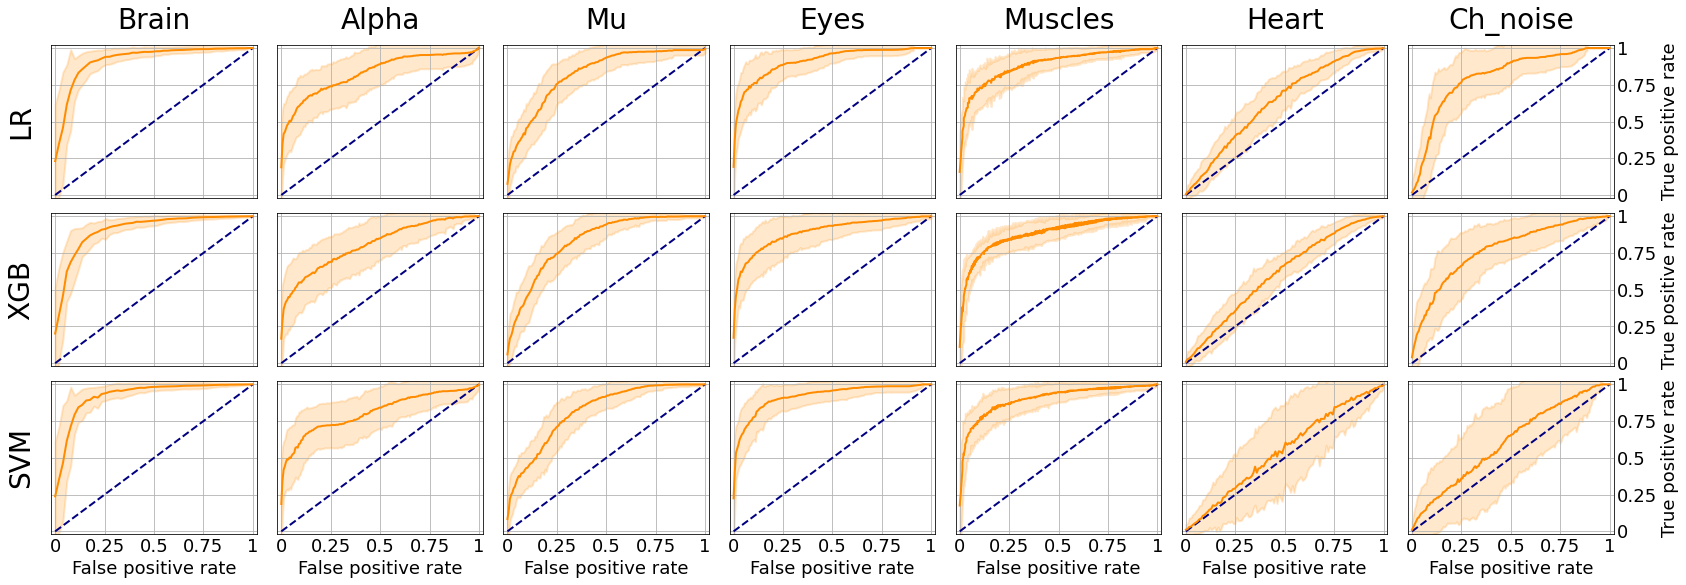

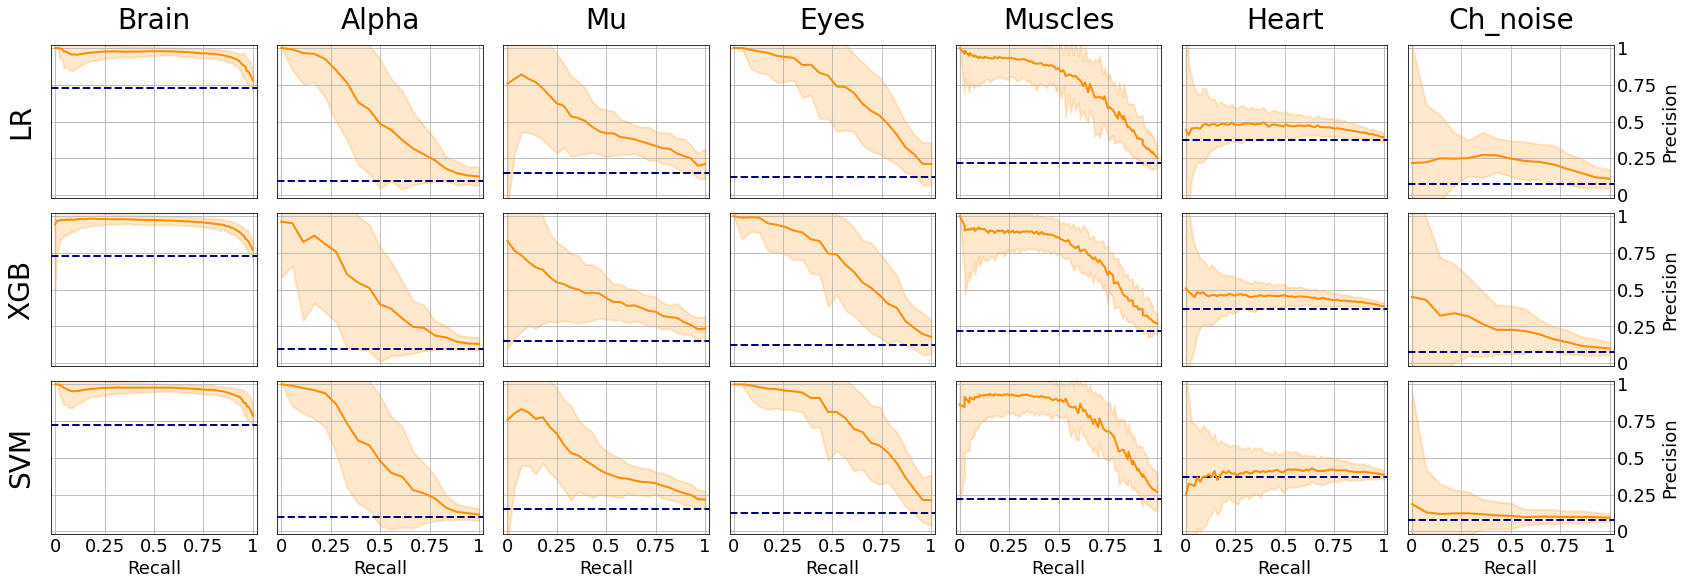

In [9]:
fig_roc, fig_pr = plot_curves_grid(features, targets, models)

In [31]:
# fig_roc.savefig('images/roc-curves_out.png', dpi=350)
fig_pr.savefig('images/pr-curves_out.png', dpi=350)

In [24]:
fig_pr.savefig('pr-curves_out.png', dpi=350)

In [15]:
def repeated_train_test(features, target, model, n_repeats, test_size=0.3, axes=None, random_state=57):
    y_true = []
    y_probs = []
    np.random.seed(random_state)

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, stratify=target)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        # roc_aucs.append(roc_auc_score(y_test, y_proba))
        # f1_scores.append(f1_score(y_test, y_pred))
        y_true.append(y_test)
        y_probs.append(y_proba)

    return np.array(y_true), np.array(y_probs)
    #     if axes is not None:
    #         plot_roc_curve(axes[0], y_test, y_proba, alpha=.1)
    #         plot_f1_curve(axes[1], y_test, y_proba, alpha=.1)

    # if axes is not None:
    #     for ax in axes:
    #         ax.set_xticks([])
    #         ax.set_yticks([])
    #         ax.set_xlabel('')
    #         ax.set_ylabel('')
    #     axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    #     axes[1].axvline(x=0.5, color='navy', lw=2, linestyle='--')
    #     axes[0].legend().remove()

    # return roc_aucs, f1_scores

# def plot_curves_grid(features, targets, models):
    
#     fig_auc, axes_auc = plt.subplots(len(models), len(targets.columns), figsize=(4 * len(targets.columns), 3 * len(models)))
#     fig_f1, axes_f1 = plt.subplots(len(models), len(targets.columns), figsize=(4 * len(targets.columns), 3 * len(models)))

#     for (model_name, model), row_auc, row_f1 in zip(models.items(), axes_auc, axes_f1):
#         for flag, ax_auc, ax_f1 in zip(targets, row_auc, row_f1):
#             repeated_train_test(features, targets[flag], model, n_repeats, axes=(ax_auc, ax_f1))
#             ax_auc.set_xlabel('')
#             ax_f1.set_xlabel('')
#         row_auc[0].set_ylabel(model_name, fontsize=30, labelpad=16)
#         row_f1[0].set_ylabel(model_name, fontsize=30, labelpad=16)
#     for target_name, ax_auc, ax_f1 in zip(targets, axes_auc[0], axes_f1[0]):
#         ax_auc.set_title(target_name[5:].capitalize(), fontsize=30, pad=16)
#         ax_f1.set_title(target_name[5:].capitalize(), fontsize=30, pad=16)

#     fig_auc.subplots_adjust(wspace=0.05, hspace=0.1)
#     fig_f1.subplots_adjust(wspace=0.05, hspace=0.1)

#     return fig_auc, fig_f1

In [15]:
from itertools import product

contingency_means = {model: pd.DataFrame(index=targets, dtype=float) for model in models
# contingency_stds = pd.DataFrame(index=models, dtype=float)


for (model_name, model), flag in product(models.items(), targets):
    true, preds = repeated_train_test(features, targets[flag], model, n_repeats)
    for type, (i, j) in zip(['TN', 'FP', 'FN', 'TP'], product([0, 1], repeat=2)):
        answer_type = np.sum((true == i) & (preds == j), axis=1)
        contingency_means[model_name].loc[flag, type] = answer_type.mean()
        # contingency_stds.loc[model_name, type] = answer_type.std()



SyntaxError: invalid syntax (<ipython-input-15-eaa49a863a5e>, line 7)

In [7]:
contingency_means

,TN,FP,FN,TP
LR,161.38,1.62,11.78,11.22
XGB,159.44,3.56,10.40,12.60
SVM,161.94,1.06,11.76,11.24


In [8]:
contingency_stds

,TN,FP,FN,TP
LR,1.037111,1.037111,2.012859,2.012859
XGB,1.745394,1.745394,2.332381,2.332381
SVM,0.925419,0.925419,2.015540,2.015540


In [29]:
TPs

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
LR,TP: 127.72,TP: 6.38,TP: 5.54,TP: 11.22,TP: 21.98,TP: 5.74,TP: 0.00
XGB,TP: 124.68,TP: 7.12,TP: 8.92,TP: 12.60,TP: 25.16,TP: 25.14,TP: 1.70
SVM,TP: 127.00,TP: 4.98,TP: 3.38,TP: 11.24,TP: 24.82,TP: 0.22,TP: 0.00


In [30]:
TNs

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
LR,TN: 37.24,TN: 167.38,TN: 155.84,TN: 161.38,TN: 141.46,TN: 110.02,TN: 171.64
XGB,TN: 37.62,TN: 165.16,TN: 149.90,TN: 159.44,TN: 138.38,TN: 87.08,TN: 169.50
SVM,TN: 38.34,TN: 167.58,TN: 157.12,TN: 161.94,TN: 141.64,TN: 116.48,TN: 172.00


In [31]:
FPs

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
LR,FP: 13.76,FP: 0.62,FP: 2.16,FP: 1.62,FP: 4.08,FP: 6.98,FP: 0.36
XGB,FP: 13.38,FP: 2.84,FP: 8.10,FP: 3.56,FP: 7.20,FP: 29.92,FP: 2.50
SVM,FP: 12.66,FP: 0.42,FP: 0.88,FP: 1.06,FP: 3.90,FP: 0.52,FP: 0.00


In [32]:
FNs

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
LR,FN: 7.28,FN: 11.62,FN: 22.46,FN: 11.78,FN: 18.48,FN: 63.26,FN: 14.00
XGB,FN: 10.32,FN: 10.88,FN: 19.08,FN: 10.40,FN: 15.26,FN: 43.86,FN: 12.30
SVM,FN: 8.00,FN: 13.02,FN: 24.62,FN: 11.76,FN: 15.64,FN: 68.78,FN: 14.00
